In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from unidecode import unidecode
import re

import networkx as nx

import plotly
from plotly.graph_objs import Scatter, Layout, Bar

import glob
import yaml
import copy

In [2]:
data = pd.read_csv("./pages-hits.csv", index_col="Page")
del data['Page Value']
data = data.drop(["/", np.NaN, "/tag/", "/everything/"])
data.reset_index(inplace=True)
data['Page'] = data['Page'].apply(lambda x: int(x[1:-1]))
data.set_index('Page', inplace=True)

tags_over_time = [[]]


def get_tags(filename):
    lines = open(filename, "r").readlines()

    yaml.reader.Reader.NON_PRINTABLE = re.compile(
    u'[^\x09\x0A\x0D\x20-\x7E\x85\xA0-\uD7FF\uE000-\uFFFD\U00010000-\U0010FFFF]')
    info = yaml.load(
        "".join(lines[1:lines.index("---\n", 2)])
    )
    return info['tags']

tag_lookup = {
    filename.split("-")[-1].split('.')[0]: get_tags(filename)
    for filename in glob.glob("../_posts/*.md")
}

tags = {}
for post, ts in tag_lookup.items():
    tags_over_time.append(set(copy.copy(tags_over_time[-1])))
    for tag in ts:
        if tag not in tags:
            tags[tag] = 0
        tags_over_time[-1].add(tag)

tag_uses = {}
for post, ts in tag_lookup.items():
    for tag in ts:
        if tag not in tag_uses:
            tag_uses[tag] = 0
        tag_uses[tag] += 1

In [3]:
for page, ts in tag_lookup.items():
    page = int(page)
    if page in data.index:
        views = data.loc[page, "Pageviews"]
        for t in ts:
            try:
                tags[t] += int(views)
            except:
                print(views)

In [4]:
tag_names = [t for t in tags.keys()]
tag_views = [tags[t] for t in tag_names]
tag_occurs = [tag_uses[t] for t in tag_names]

plotly.offline.init_notebook_mode(connected=True)

_data = Scatter(
    y=tag_views, x=tag_occurs,
    text=tag_names,
    mode= 'markers',
)
fig = plotly.graph_objs.Figure(data=[_data], layout=Layout(
    title= 'Tag Popularity and Usage',
    hovermode= 'closest',
    xaxis= dict(
        type="log",
        title= 'Tag Use (Number of Posts)',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        type="log",
        title= 'Tag Views (Number of Unique Viewers)',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
))
plotly.offline.iplot(fig)

<IPython.core.display.Javascript object>


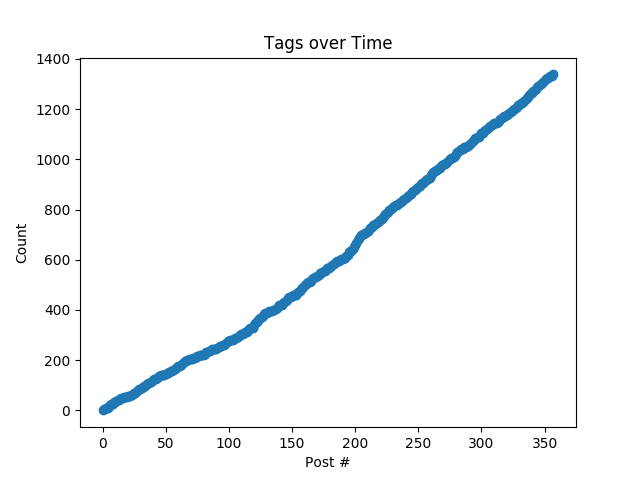

In [5]:
plt.figure()
plt.title("Tags over Time")
plt.xlabel("Post #")
plt.ylabel("Count")
plt.scatter(list(range(len(tags_over_time))), [len(r) for r in tags_over_time])

In [6]:
print("{} distinct tagnames".format(len(tag_names)))

1338 distinct tagnames


In [7]:
sorted_tags = sorted(tags.items(), key=lambda x: x[1], reverse=True)

plotly.offline.iplot(plotly.graph_objs.Figure(
    data=[
        Bar(
            x=[i[0] for i in sorted_tags],
            y=[i[1] for i in sorted_tags],
        )
    ], layout=Layout(
    title= 'Tag Use',
    hovermode= 'closest',
    xaxis= dict(
#         title= 'Tag',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
#         dtick=1
    ),
    yaxis=dict(
        title= 'Tag Frequency',
        ticklen= 5,
        gridwidth= 2,
        type="log"
        
    ),
    showlegend= False
)))

In [8]:
sorted_tags = sorted(tags.keys())
cooccurrence_matrix = np.zeros((len(tags), len(tags)))
tss = tag_lookup.items()
for _, ts in tss:
    for i in ts:
        for j in ts:
            if i != j:
                cooccurrence_matrix[sorted_tags.index(i), sorted_tags.index(j)] += 1

<IPython.core.display.Javascript object>


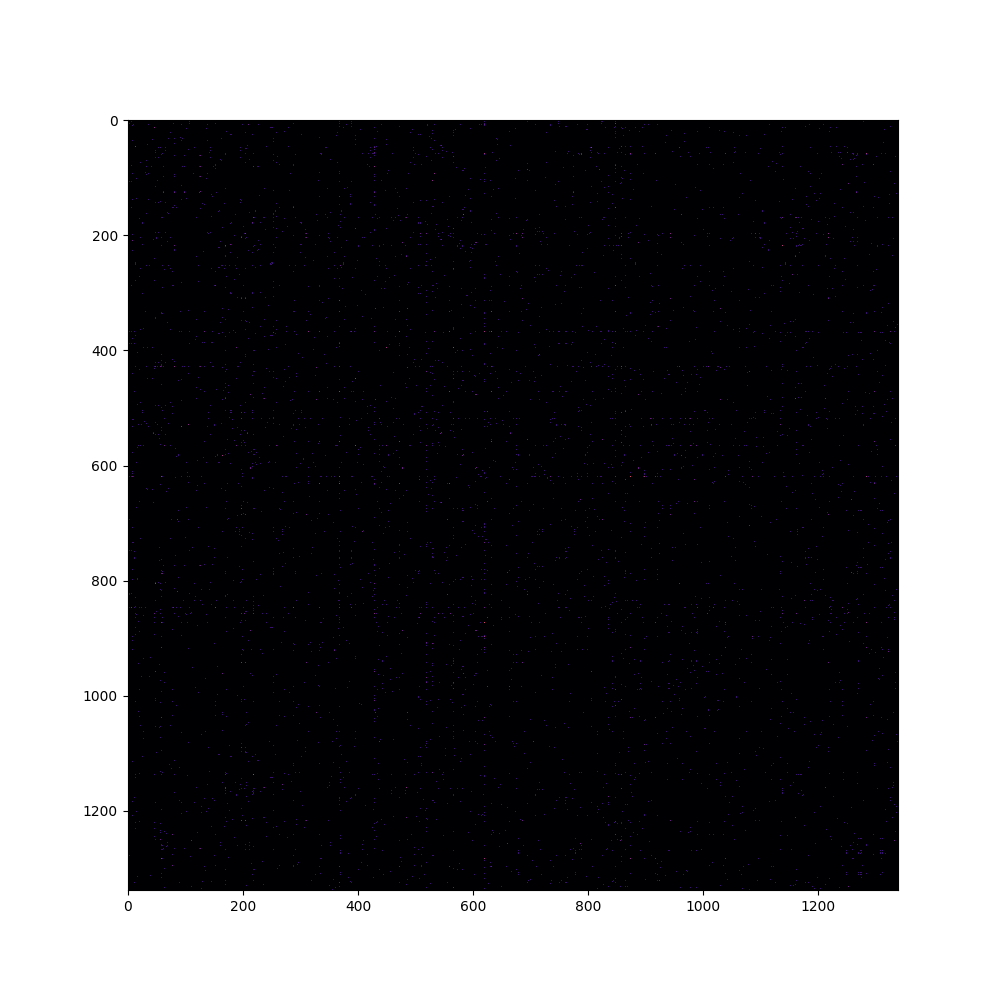

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log(cooccurrence_matrix+1), cmap="magma")

<IPython.core.display.Javascript object>


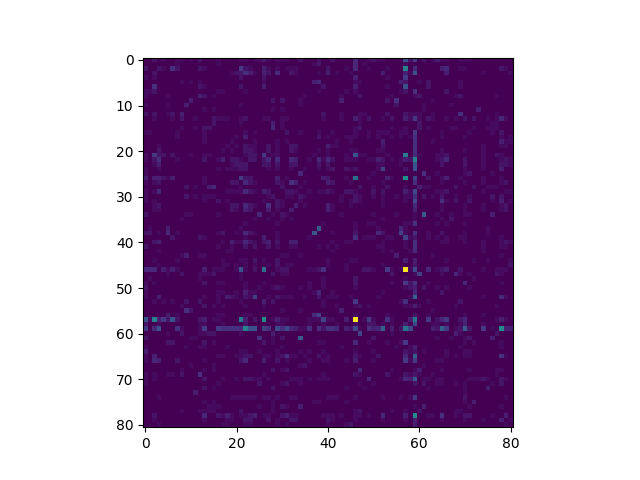

In [10]:
cooccurrence_matrix_useful = cooccurrence_matrix[:]
REMOVE_TAGS_LESS_POPULAR_THAN = 40

delete_rows = []
for i in range(len(cooccurrence_matrix_useful)):
    if (
        np.sum(cooccurrence_matrix_useful[i]) == np.max(cooccurrence_matrix_useful[i]) or 
        np.sum(cooccurrence_matrix_useful[i]) <= REMOVE_TAGS_LESS_POPULAR_THAN
    ):
        delete_rows.append(i)

cooccurrence_matrix_useful = np.delete(cooccurrence_matrix_useful, delete_rows, 1)
cooccurrence_matrix_useful = np.delete(cooccurrence_matrix_useful, delete_rows, 0)
taggies = np.delete(sorted_tags, delete_rows, 0)

plt.figure()
plt.imshow(cooccurrence_matrix_useful)
plt.show()

In [ ]:
G = nx.from_numpy_matrix(cooccurrence_matrix_useful.astype('uint8'))
_weights = dict(nx.get_edge_attributes(G, 'weight'))
_weights_norm = {k: v/max(_weights.values()) for k, v in dict(nx.get_edge_attributes(G, 'weight')).items()}

G_all = nx.from_numpy_matrix(cooccurrence_matrix.astype('uint8'))
_weights = dict(nx.get_edge_attributes(G_all, 'weight'))
_weights_norm = {k: v/max(_weights.values()) for k, v in dict(nx.get_edge_attributes(G_all, 'weight')).items()}

In [ ]:
plt.figure(figsize=(40, 40))
pos = nx.layout.spring_layout(G, k=0.1, iterations=100)
nx.draw_networkx_nodes(G, pos=pos, node_size=1)
nx.draw_networkx_edges(G, pos=pos, width=list(_weights.values()), alpha=0.2)
nx.draw_networkx_labels(G, pos=pos, labels={i: n for i, n in enumerate(taggies)}, font_size=6)
plt.show()

In [ ]:
plt.figure(figsize=(100, 100))
pos = nx.layout.spring_layout(G_all, k=0.1, iterations=100)
nx.draw_networkx_nodes(G_all, pos=pos, node_size=1)
nx.draw_networkx_edges(G_all, pos=pos, width=list(_weights.values()), alpha=0.05)
nx.draw_networkx_labels(G_all, pos=pos, labels={i: n for i, n in enumerate(sorted_tags)}, font_size=6)
plt.show()

In [ ]:
tG = nx.relabel_nodes(G, {i: n for i, n in enumerate(taggies)})
nx.write_gexf(tG, '/Users/mateljk1/365tags.gexf')